In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bert-folder/Cleaned_Nepali_dataset.csv
/kaggle/input/bert-folder/raw_dataset/raw_dataset/dataset_dict.json
/kaggle/input/bert-folder/raw_dataset/raw_dataset/validation/state.json
/kaggle/input/bert-folder/raw_dataset/raw_dataset/validation/dataset_info.json
/kaggle/input/bert-folder/raw_dataset/raw_dataset/validation/data-00000-of-00001.arrow
/kaggle/input/bert-folder/raw_dataset/raw_dataset/train/state.json
/kaggle/input/bert-folder/raw_dataset/raw_dataset/train/dataset_info.json
/kaggle/input/bert-folder/raw_dataset/raw_dataset/train/data-00000-of-00001.arrow


In [2]:
!pip install -q --upgrade pip
!pip install -q --upgrade ipywidgets 
!pip install -q datasets
!pip install -q tqdm
!pip uninstall -q -y tensorflow 
!pip uninstall -q -y keras 
!pip install -q tf-keras  # To satisfy transformers' internal requirement for now

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.17.1 which is incompatible.


In [3]:

!cp -R /kaggle/input/bert-folder/raw_dataset/raw_dataset /kaggle/working/

In [4]:
from datasets import Dataset, load_from_disk

dataset = load_from_disk("/kaggle/working/raw_dataset")

train = dataset["train"]
validation = dataset["validation"]

train = train.rename_column("label", "labels")
validation = validation.rename_column("label", "labels")

In [5]:
from collections import Counter

for k, v in dataset.items():
    print(k, Counter(dataset[k]['label']))

train Counter({0: 1807, 3: 214, 1: 200, 2: 66})
validation Counter({0: 452, 3: 53, 1: 50, 2: 17})


In [6]:
# wandb for logging, get the login key from wandb.ai/authorize
!pip install -q wandb
import wandb
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
wandb_secret = user_secrets.get_secret("wandb")
wandb.login(key=wandb_secret)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tamangangel2057 (tamangangel2057-student). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Model names

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

nephased = "Vyke2000/Nephased"
tokenizer= AutoTokenizer.from_pretrained(nephased)
bert_v1 = "Vyke2000/BERT_Classifier_no_cost_sensitive"
bert_v2 = "Vyke2000/BERT_Classifier_v1"
bert_v3 = "Vyke2000/BERT_Classifier_v2"

tokenizer_config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.14M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

In [8]:
# Generating Embeddings
def preprocess_function(document):
    return tokenizer(document["text"], truncation=True, padding='max_length')

train_tokenized= train.map(preprocess_function, batched= False,remove_columns=["text"])
validation_tokenized= validation.map(preprocess_function, batched= False,remove_columns=["text"])

# Convert to DataFrame and reorder columns
train2 = pd.DataFrame(train_tokenized)
train2 = train2[['input_ids', 'attention_mask', 'labels']]  # Set the correct order

# Convert back to Dataset
train_tokenized = Dataset.from_pandas(train2)
train_tokenized = train_tokenized.with_format("torch", columns=["input_ids", "attention_mask", "labels"])

validation2 = pd.DataFrame(validation_tokenized)
validation2 = validation2[['input_ids', 'attention_mask', 'labels']]  # Set the correct order

# Convert back to Dataset
validation_tokenized = Dataset.from_pandas(validation2)
validation_tokenized = validation_tokenized.with_format("torch", columns=["input_ids", "attention_mask", "labels"])



print(validation_tokenized.features.keys())

Map:   0%|          | 0/2287 [00:00<?, ? examples/s]

Map:   0%|          | 0/572 [00:00<?, ? examples/s]

dict_keys(['input_ids', 'attention_mask', 'labels'])


## For Learning curve we will simply take the training log from the models and hardcode the losses in an array

In [9]:
def make_learning_curve(num_of_epochs, training_loss, validation_loss, best_x, title="Learning Curve: Train and Validation Loss", xlim=(0, 10), ylim=(0, 2.5), show=True):
    # Define epochs based on num_of_epochs
    epochs = np.arange(1, num_of_epochs+1)

    # Slice losses up to num_of_epochs
    training_loss = training_loss[:num_of_epochs]
    validation_loss = validation_loss[:num_of_epochs]

    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Plot training and validation loss
    ax.plot(epochs[1:], training_loss[1:], label="Training Loss", marker="o", linestyle="-", color="blue")
    ax.plot(epochs, validation_loss, label="Validation Loss", marker="o", linestyle="-", color="red")
    
    # Highlight best model if within range
    if best_x <= num_of_epochs:
        ax.axvline(x=best_x, linestyle="--", color="green", label="Best Model")
    
    # Labels and title
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f'{title}', pad=20)
    
    plt.xlim(xlim)
    plt.ylim(ylim) 
    
    plt.legend()
    
    if show:
        plt.show()  # Show the plot
    else:
        return fig  # Return figure object for further use

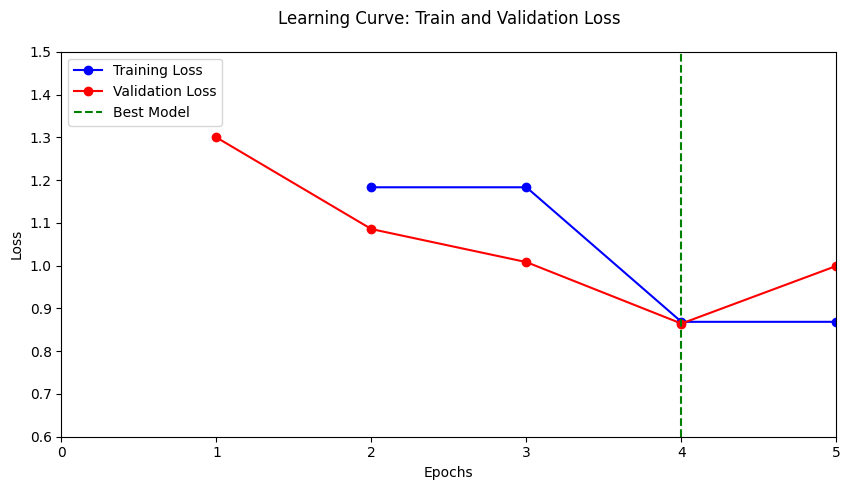

In [10]:
# For final model i.e Nephased
training_loss_nephased = np.array([None, 1.183100, 1.183100, 0.868600, 0.868600, 0.636600, 0.459300, 0.459300, 0.364300])
validation_loss_nephased = np.array([1.299673, 1.085420, 1.008179, 0.864529, 0.999262, 1.123220, 1.503293, 1.586980, 2.079169])

make_learning_curve(num_of_epochs=5, training_loss=training_loss_nephased, validation_loss=validation_loss_nephased, best_x=4, xlim=(0,5), ylim=(0.6,1.5))


## Confusion matrix

In [11]:
# For Nephased
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def generate_classification_report(y_true, y_pred, label_map, show=True):
    labels = list(label_map.values())  # Get human-readable class names
    report = classification_report(y_true=y_true, y_pred=y_pred, target_names=labels)
    if show:
        print(report)
    else:
        return report

def plot_confusion_matrix(y_true, y_pred, label_map, title="Confusion Matrix", cmap='Blues', show=True):
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    labels = [label_map[i] for i in sorted(label_map.keys())]  # Ensure correct order

    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax, cmap=cmap, values_format='d')

    ax.set_title(title)
    if show:
        plt.show()
    else:
        return fig

# Label mapping
label_map = {
    0: 'GENERAL',
    1: 'PROFANITY_0',
    2: 'PROFANITY_1',
    3: 'VIOLENCE'
}



In [12]:

wandb.init()

wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250220_114309-n36o2baf
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run lemon-eon-8
wandb: ⭐️ View project at https://wandb.ai/tamangangel2057-student/uncategorized
wandb: 🚀 View run at https://wandb.ai/tamangangel2057-student/uncategorized/runs/n36o2baf


In [13]:
# Load pre-trained Model
model_nephased= AutoModelForSequenceClassification.from_pretrained(nephased, num_labels=4)

config.json:   0%|          | 0.00/765 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [14]:
# Evaluation Setup
import torch
from torch import nn
import pickle
from scipy.special import softmax
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score

def compute_metrics_nephased(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    probabilities = softmax(logits, axis=-1)  

    report = classification_report(y_true=labels, y_pred=predictions, output_dict=True)

    accuracy = report['accuracy']
    recall = report['macro avg']['recall']
    precision = report['macro avg']['precision']
    f1 = report['macro avg']['f1-score']
    
    # Get number of classes
    num_classes = probabilities.shape[1]
    
    precision_all = []
    recall_all = []
    pr_auc_all = np.zeros(num_classes)

    for i in range(num_classes):
        binary_labels = (labels == i).astype(int)
        prec, rec, _ = precision_recall_curve(binary_labels, probabilities[:, i])
        precision_all.append(prec)
        recall_all.append(rec)
        pr_auc_all[i] = average_precision_score(binary_labels, probabilities[:, i])
        
    # Compute Macro-Average PR Curve
    precision_macro = []
    recall_macro = []
    for i in range(num_classes):
        binary_labels = (labels == i).astype(int)
        prec, rec, _ = precision_recall_curve(binary_labels, probabilities[:, i])
        precision_macro.append(np.interp(np.linspace(0, 1, 100), rec[::-1], prec[::-1]))  # Interpolation for averaging
        recall_macro.append(np.linspace(0, 1, 100))

    precision_macro = np.mean(precision_macro, axis=0)
    recall_macro = np.linspace(0, 1, 100)
    pr_auc_macro = np.mean(pr_auc_all)

    # Save PR curve data
    pr_data = {
        "pr_auc": pr_auc_all, 
        "precision": precision_all, 
        "recall": recall_all, 
        "pr_auc_macro": pr_auc_macro,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro
    }
    with open("/kaggle/working/pr_data.pkl", "wb") as f:
        pickle.dump(pr_data, f)
    
    return {
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1": f1
    }

In [15]:
from transformers import TrainingArguments, Trainer

run_name= "Nephased_validation"
output_dir = "/kaggle/working/Nephased"

training_args_nephased = TrainingArguments(
    output_dir=output_dir,
    run_name=run_name,
    do_train=False,
    eval_strategy="epoch",
    per_device_train_batch_size=4, # Each device takes this batch, so 2 T4 GPU each take 4 making 8
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=1,
    warmup_ratio= 0.17707559519779958,
    save_total_limit=1,
    learning_rate=1.9165942005355648e-05,
    num_train_epochs=20,
    weight_decay=0.09172868307357833,
    report_to="wandb",
    push_to_hub=False,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True,
    save_strategy = "epoch",
    greater_is_better=True,
    overwrite_output_dir= True,
    bf16=True,
    seed= 42,
)

trainer_nephased = Trainer(
    model=model_nephased,
    args=training_args_nephased,
    train_dataset=train_tokenized,
    eval_dataset=validation_tokenized,
    compute_metrics=compute_metrics_nephased,
)

              precision    recall  f1-score   support

     GENERAL       0.91      0.85      0.88       452
 PROFANITY_0       0.36      0.60      0.45        50
 PROFANITY_1       0.86      0.71      0.77        17
    VIOLENCE       0.42      0.42      0.42        53

    accuracy                           0.78       572
   macro avg       0.64      0.64      0.63       572
weighted avg       0.81      0.78      0.79       572



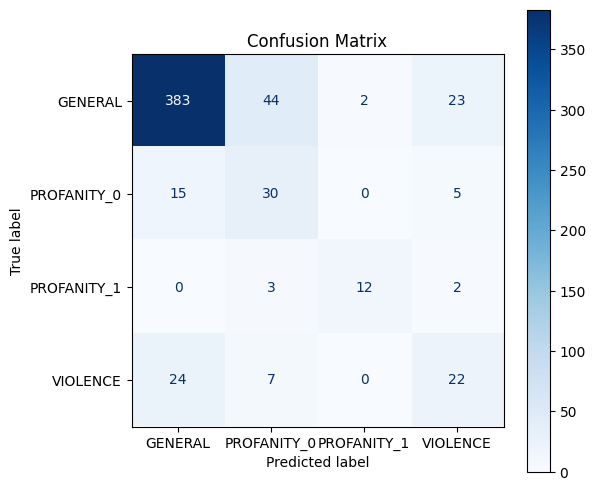

In [16]:
# Predict and get final predictions_nephased
predictions_nephased = trainer_nephased.predict(validation_tokenized)
final_predictions_nephased = np.argmax(predictions_nephased.predictions, axis=1)

# Convert tensor labels to integers
y_true = [x.item() if isinstance(x, torch.Tensor) else x for x in validation_tokenized['labels']]
y_pred_nephased = final_predictions_nephased

# Generate classification report
generate_classification_report(y_true, y_pred_nephased, label_map)

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred_nephased, label_map)


In [17]:
import huggingface_hub
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
hf_secret = user_secrets.get_secret("hf")

huggingface_hub.login(token=hf_secret)

config.json:   0%|          | 0.00/814 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

              precision    recall  f1-score   support

     GENERAL       0.86      0.87      0.86       452
 PROFANITY_0       0.23      0.22      0.23        50
 PROFANITY_1       0.69      0.53      0.60        17
    VIOLENCE       0.30      0.30      0.30        53

    accuracy                           0.75       572
   macro avg       0.52      0.48      0.50       572
weighted avg       0.75      0.75      0.75       572



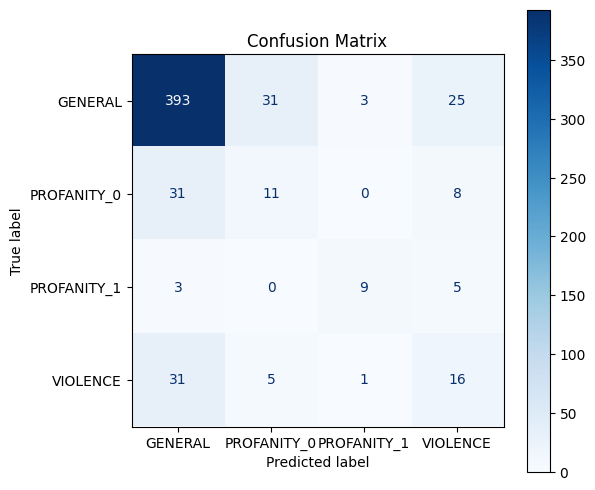

In [18]:
def compute_metrics_no_cost(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    probabilities = softmax(logits, axis=-1)  

    report = classification_report(y_true=labels, y_pred=predictions, output_dict=True)

    accuracy = report['accuracy']
    recall = report['macro avg']['recall']
    precision = report['macro avg']['precision']
    f1 = report['macro avg']['f1-score']
    
    # Get number of classes
    num_classes = probabilities.shape[1]
    
    precision_all = []
    recall_all = []
    pr_auc_all = np.zeros(num_classes)

    for i in range(num_classes):
        binary_labels = (labels == i).astype(int)
        prec, rec, _ = precision_recall_curve(binary_labels, probabilities[:, i])
        precision_all.append(prec)
        recall_all.append(rec)
        pr_auc_all[i] = average_precision_score(binary_labels, probabilities[:, i])
        
    # Compute Macro-Average PR Curve
    precision_macro = []
    recall_macro = []
    for i in range(num_classes):
        binary_labels = (labels == i).astype(int)
        prec, rec, _ = precision_recall_curve(binary_labels, probabilities[:, i])
        precision_macro.append(np.interp(np.linspace(0, 1, 100), rec[::-1], prec[::-1]))  # Interpolation for averaging
        recall_macro.append(np.linspace(0, 1, 100))

    precision_macro = np.mean(precision_macro, axis=0)
    recall_macro = np.linspace(0, 1, 100)
    pr_auc_macro = np.mean(pr_auc_all)

    # Save PR curve data
    pr_data = {
        "pr_auc": pr_auc_all, 
        "precision": precision_all, 
        "recall": recall_all, 
        "pr_auc_macro": pr_auc_macro,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro
    }
    with open("/kaggle/working/pr_data_no_cost.pkl", "wb") as f:
        pickle.dump(pr_data, f)
    
    return {
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1": f1
    }

training_args_no_cost = TrainingArguments(
    output_dir=output_dir,
    run_name=run_name,
    eval_strategy="epoch",
    per_device_train_batch_size=4, # Each device takes this batch, so 2 T4 GPU each take 4 making 8
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    warmup_ratio= 0.1,
    save_strategy="epoch",
    save_on_each_node=True,
    learning_rate=1e-5,
    num_train_epochs=20,
    weight_decay=0.01,
    report_to="wandb",
    push_to_hub=False,
    save_total_limit= 1,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True,
    greater_is_better=True,
    overwrite_output_dir= True,
    bf16=True,
)

# Load pre-trained Model
model_v1= AutoModelForSequenceClassification.from_pretrained(bert_v1, num_labels=4)

trainer_no_cost = Trainer(
    model=model_v1,
    args=training_args_no_cost,
    train_dataset=train_tokenized,
    eval_dataset=validation_tokenized,
    compute_metrics=compute_metrics_no_cost,
)

# Predict and get final predictions_no_cost
predictions_no_cost = trainer_no_cost.predict(validation_tokenized)
final_predictions_no_cost = np.argmax(predictions_no_cost.predictions, axis=1)

# Convert tensor labels to integers
y_true = [x.item() if isinstance(x, torch.Tensor) else x for x in validation_tokenized['labels']]
y_pred_no_cost = final_predictions_no_cost

# Generate classification report
generate_classification_report(y_true, y_pred_no_cost, label_map)

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred_no_cost, label_map)


config.json:   0%|          | 0.00/765 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

              precision    recall  f1-score   support

     GENERAL       0.94      0.76      0.84       452
 PROFANITY_0       0.27      0.56      0.36        50
 PROFANITY_1       0.48      0.65      0.55        17
    VIOLENCE       0.37      0.55      0.44        53

    accuracy                           0.72       572
   macro avg       0.51      0.63      0.55       572
weighted avg       0.82      0.72      0.76       572



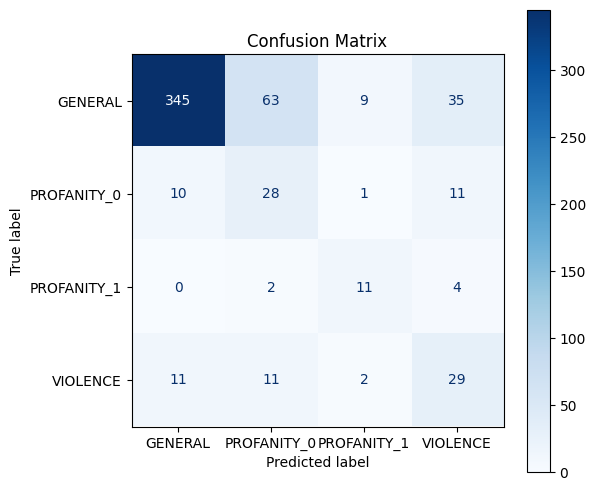

In [19]:
def compute_metrics_v1(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    probabilities = softmax(logits, axis=-1)  

    report = classification_report(y_true=labels, y_pred=predictions, output_dict=True)

    accuracy = report['accuracy']
    recall = report['macro avg']['recall']
    precision = report['macro avg']['precision']
    f1 = report['macro avg']['f1-score']
    
    # Get number of classes
    num_classes = probabilities.shape[1]
    
    precision_all = []
    recall_all = []
    pr_auc_all = np.zeros(num_classes)

    for i in range(num_classes):
        binary_labels = (labels == i).astype(int)
        prec, rec, _ = precision_recall_curve(binary_labels, probabilities[:, i])
        precision_all.append(prec)
        recall_all.append(rec)
        pr_auc_all[i] = average_precision_score(binary_labels, probabilities[:, i])
        
    # Compute Macro-Average PR Curve
    precision_macro = []
    recall_macro = []
    for i in range(num_classes):
        binary_labels = (labels == i).astype(int)
        prec, rec, _ = precision_recall_curve(binary_labels, probabilities[:, i])
        precision_macro.append(np.interp(np.linspace(0, 1, 100), rec[::-1], prec[::-1]))  # Interpolation for averaging
        recall_macro.append(np.linspace(0, 1, 100))

    precision_macro = np.mean(precision_macro, axis=0)
    recall_macro = np.linspace(0, 1, 100)
    pr_auc_macro = np.mean(pr_auc_all)

    # Save PR curve data
    pr_data = {
        "pr_auc": pr_auc_all, 
        "precision": precision_all, 
        "recall": recall_all, 
        "pr_auc_macro": pr_auc_macro,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro
    }
    with open("/kaggle/working/pr_data_v1.pkl", "wb") as f:
        pickle.dump(pr_data, f)
    
    return {
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1": f1
    }

training_args_v1 = TrainingArguments(
    output_dir=output_dir,
    run_name=run_name,
    eval_strategy="epoch",
    per_device_train_batch_size=4, # Each device takes this batch, so 2 T4 GPU each take 4 making 8
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    warmup_ratio= 0.1,
    save_strategy="epoch",
    save_on_each_node=True,
    learning_rate=1e-5,
    num_train_epochs=20,
    weight_decay=0.01,
    report_to="wandb",
    push_to_hub=False,
    save_total_limit= 1,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True,
    greater_is_better=True,
    overwrite_output_dir= True,
    bf16=True,
)

# Load pre-trained Model
model_v2= AutoModelForSequenceClassification.from_pretrained(bert_v2, num_labels=4)

trainer_v1 = Trainer(
    model=model_v2,
    args=training_args_v1,
    train_dataset=train_tokenized,
    eval_dataset=validation_tokenized,
    compute_metrics=compute_metrics_v1,
)

# Predict and get final predictions_v1
predictions_v1 = trainer_v1.predict(validation_tokenized)
final_predictions_v1 = np.argmax(predictions_v1.predictions, axis=1)

# Convert tensor labels to integers
y_true = [x.item() if isinstance(x, torch.Tensor) else x for x in validation_tokenized['labels']]
y_pred_v1 = final_predictions_v1

# Generate classification report
generate_classification_report(y_true, y_pred_v1, label_map)

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred_v1, label_map)


config.json:   0%|          | 0.00/840 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

              precision    recall  f1-score   support

     GENERAL       0.94      0.79      0.86       452
 PROFANITY_0       0.32      0.70      0.44        50
 PROFANITY_1       0.57      0.76      0.65        17
    VIOLENCE       0.49      0.55      0.52        53

    accuracy                           0.76       572
   macro avg       0.58      0.70      0.62       572
weighted avg       0.83      0.76      0.78       572



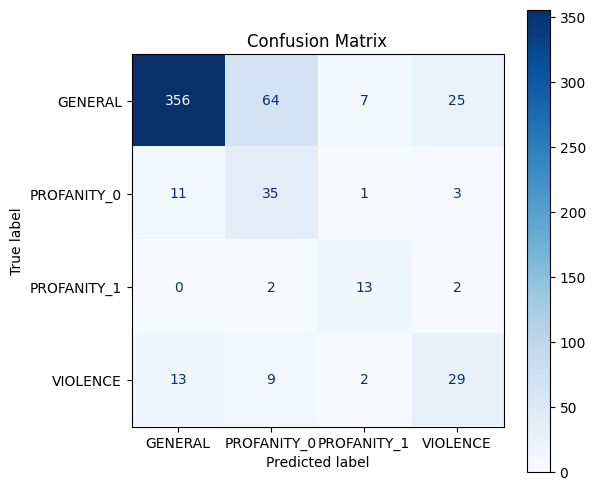

In [20]:
def compute_metrics_v2(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    probabilities = softmax(logits, axis=-1)  

    report = classification_report(y_true=labels, y_pred=predictions, output_dict=True)

    accuracy = report['accuracy']
    recall = report['macro avg']['recall']
    precision = report['macro avg']['precision']
    f1 = report['macro avg']['f1-score']
    
    # Get number of classes
    num_classes = probabilities.shape[1]
    
    precision_all = []
    recall_all = []
    pr_auc_all = np.zeros(num_classes)

    for i in range(num_classes):
        binary_labels = (labels == i).astype(int)
        prec, rec, _ = precision_recall_curve(binary_labels, probabilities[:, i])
        precision_all.append(prec)
        recall_all.append(rec)
        pr_auc_all[i] = average_precision_score(binary_labels, probabilities[:, i])
        
    # Compute Macro-Average PR Curve
    precision_macro = []
    recall_macro = []
    for i in range(num_classes):
        binary_labels = (labels == i).astype(int)
        prec, rec, _ = precision_recall_curve(binary_labels, probabilities[:, i])
        precision_macro.append(np.interp(np.linspace(0, 1, 100), rec[::-1], prec[::-1]))  # Interpolation for averaging
        recall_macro.append(np.linspace(0, 1, 100))

    precision_macro = np.mean(precision_macro, axis=0)
    recall_macro = np.linspace(0, 1, 100)
    pr_auc_macro = np.mean(pr_auc_all)

    # Save PR curve data
    pr_data = {
        "pr_auc": pr_auc_all, 
        "precision": precision_all, 
        "recall": recall_all, 
        "pr_auc_macro": pr_auc_macro,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro
    }
    
    with open("/kaggle/working/pr_data_v2.pkl", "wb") as f:
        pickle.dump(pr_data, f)
    
    return {
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1": f1
    }

training_args_v2 = TrainingArguments(
    output_dir=output_dir,
    run_name=run_name,
    eval_strategy="epoch",
    per_device_train_batch_size=4, # Each device takes this batch, so 2 T4 GPU each take 4 making 8
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=1,
    warmup_ratio= 0.17707559519779958,
    learning_rate=1.9165942005355648e-05,
    num_train_epochs=20,
    weight_decay=0.09172868307357833,
    report_to="wandb",
    push_to_hub=False,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True,
    save_strategy = "epoch",
    greater_is_better=True,
    overwrite_output_dir= True,
    bf16=True,
    seed= 42,
)

# Load pre-trained Model
model_v3= AutoModelForSequenceClassification.from_pretrained(bert_v3, num_labels=4)

trainer_v2 = Trainer(
    model=model_v3,
    args=training_args_v2,
    train_dataset=train_tokenized,
    eval_dataset=validation_tokenized,
    compute_metrics=compute_metrics_v2,
)

# Predict and get final predictions_v2
predictions_v2 = trainer_v2.predict(validation_tokenized)
final_predictions_v2 = np.argmax(predictions_v2.predictions, axis=1)

# Convert tensor labels to integers
y_true = [x.item() if isinstance(x, torch.Tensor) else x for x in validation_tokenized['labels']]
y_pred_v2 = final_predictions_v2

# Generate classification report
generate_classification_report(y_true, y_pred_v2, label_map)

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred_v2, label_map)


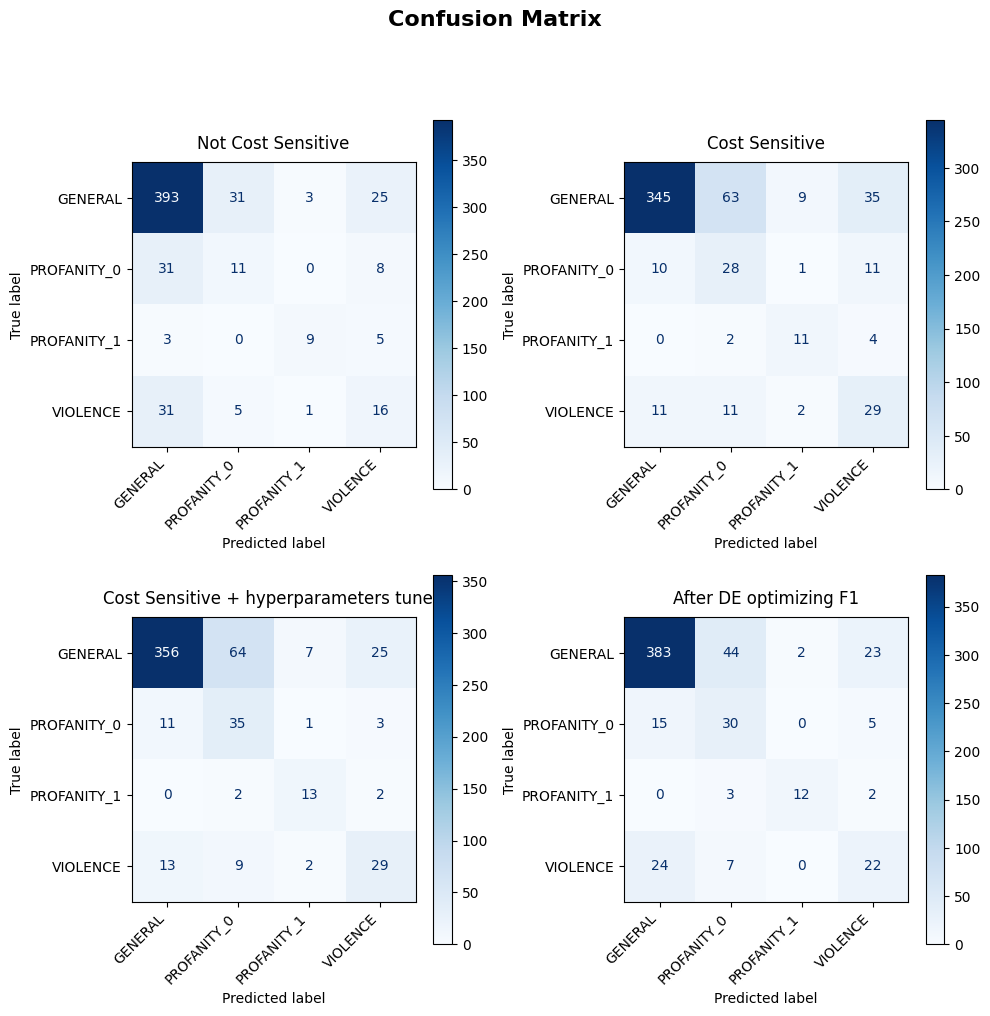

In [21]:
def plot_multiple_confusion_matrices(y_true, y_preds, label_map, titles, cmap='Blues'):
    num_matrices = len(y_preds)  # Number of confusion matrices to plot
    fig, axes = plt.subplots(2,2, figsize=(10,10))  # Create subplots

    fig.suptitle("Confusion Matrix", fontsize=16, fontweight='bold', y=1.02)
    
    if num_matrices == 1:  # Handle single plot case
        axes = [axes]  

    labels = [label_map[i] for i in sorted(label_map.keys())]  

    # Ensure exactly 4 elements
    while len(y_preds) < 4:
        y_preds.append(np.zeros_like(y_true))  # Dummy predictions
    while len(titles) < 4:
        titles.append("Untitled")
        
    for ax, y_pred, title in zip(axes.flat, y_preds, titles):
        cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot(ax=ax, cmap=cmap, values_format='d')  # Assign confusion matrix to subplot

        ax.set_title(title, fontsize=12, pad=10)  # Set title for each subplot
        ax.set_xticklabels(labels, rotation=45, ha="right")  # Rotate labels for better readability
        ax.set_yticklabels(labels)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig("/kaggle/working/conf.png", bbox_inches='tight', dpi=300)
    plt.show()
    

# Titles for each confusion matrix
titles = [
    "Not Cost Sensitive",
    "Cost Sensitive",
    "Cost Sensitive + hyperparameters tuned",
    "After DE optimizing F1"
]

# Predictions from different models
y_preds = [y_pred_no_cost, y_pred_v1, y_pred_v2, y_pred_nephased]

# Call the function to generate all confusion matrices in one figure
plot_multiple_confusion_matrices(y_true, y_preds, label_map, titles)

## PR curve

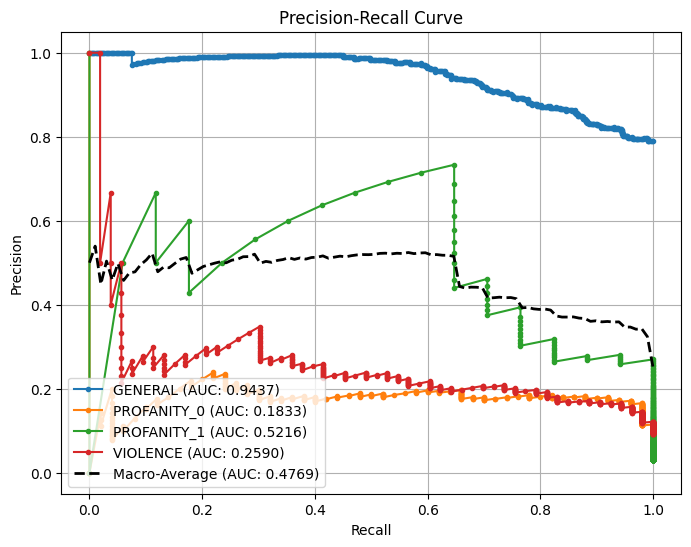

In [22]:
import pickle
import matplotlib.pyplot as plt

def plot_pr_curve_from_file(file_path, save_path=None):
    # Load the PR curve data
    with open(file_path, "rb") as f:
        pr_data = pickle.load(f)

    # Extract precision-recall values
    precision_all = pr_data["precision"]
    recall_all = pr_data["recall"]
    pr_auc_all = pr_data["pr_auc"]
    
    # Macro-average PR values
    precision_macro = pr_data["precision_macro"]
    recall_macro = pr_data["recall_macro"]
    pr_auc_macro = pr_data["pr_auc_macro"]

    # Convert label indices to class names using label_map
    class_labels = [label_map[i] for i in sorted(label_map.keys())]

    # Plot PR curves for all classes
    plt.figure(figsize=(8, 6))
    for precision, recall, pr_auc, label in zip(precision_all, recall_all, pr_auc_all, class_labels):
        plt.plot(recall, precision, marker='.', label=f"{label} (AUC: {pr_auc:.4f})")

    # Plot the macro-average PR curve
    plt.plot(recall_macro, precision_macro, linestyle="--", linewidth=2, color="black", 
             label=f"Macro-Average (AUC: {pr_auc_macro:.4f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="lower left")
    plt.grid(True)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"PR curve saved at {save_path}")

    plt.show()

# For no cost
plot_pr_curve_from_file("/kaggle/working/pr_data_no_cost.pkl",)


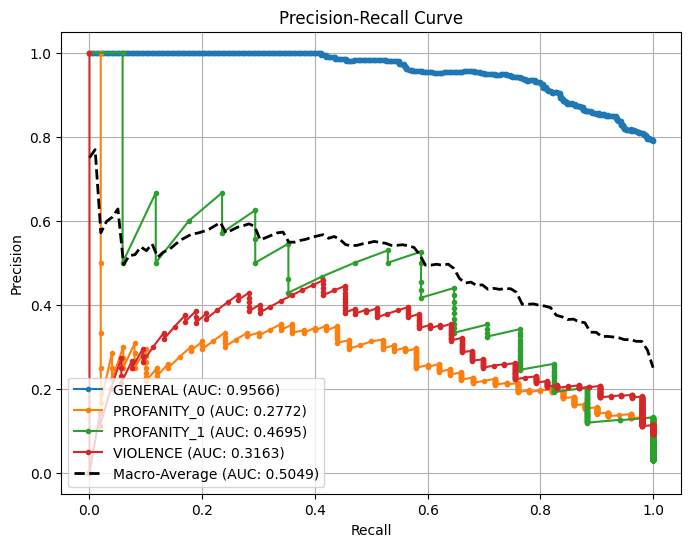

In [23]:
plot_pr_curve_from_file("/kaggle/working/pr_data_v1.pkl",)

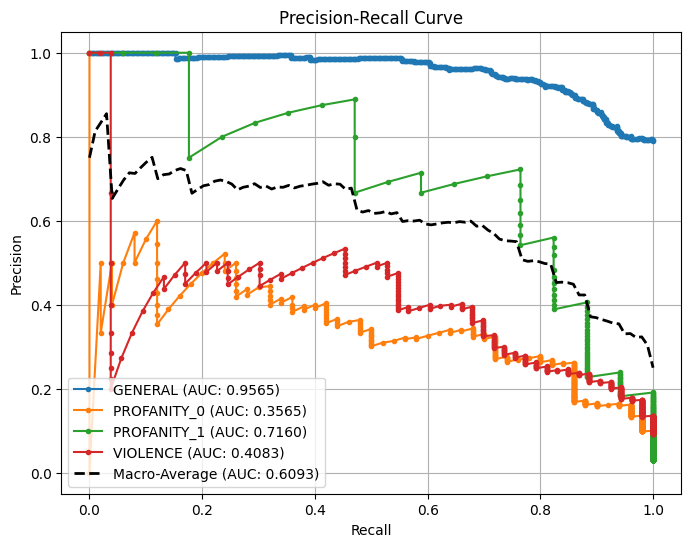

In [24]:
plot_pr_curve_from_file("/kaggle/working/pr_data_v2.pkl",)

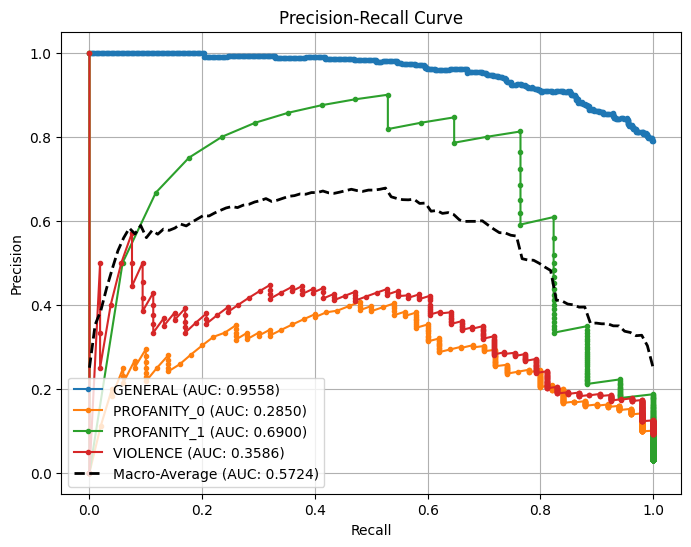

In [25]:
plot_pr_curve_from_file("/kaggle/working/pr_data.pkl",)

PR curve grid saved at /kaggle/working/pr_curves.png


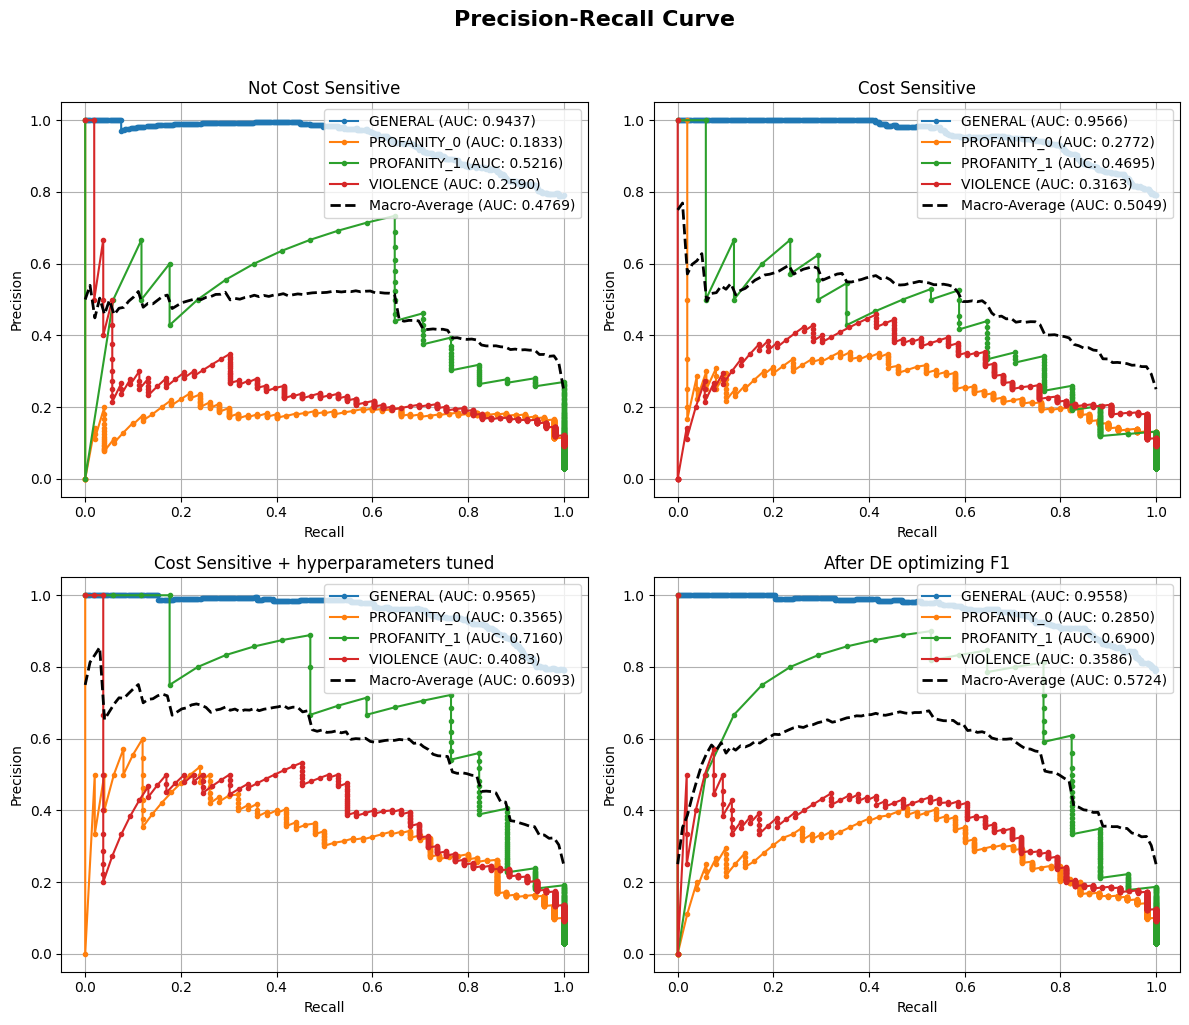

In [26]:
def plot_pr_curves_grid(file_paths, label_map, titles, save_path=None):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()  # Flatten to easily iterate over subplots
   
    fig.suptitle("Precision-Recall Curve", fontsize=16, fontweight='bold', y=1.02)

    for i, (file_path, title) in enumerate(zip(file_paths, titles)):
        # Load PR curve data
        with open(file_path, "rb") as f:
            pr_data = pickle.load(f)

        # Extract precision-recall values
        precision_all = pr_data["precision"]
        recall_all = pr_data["recall"]
        pr_auc_all = pr_data["pr_auc"]
        
        # Macro-average PR values
        precision_macro = pr_data["precision_macro"]
        recall_macro = pr_data["recall_macro"]
        pr_auc_macro = pr_data["pr_auc_macro"]

        # Convert label indices to class names
        class_labels = [label_map[i] for i in sorted(label_map.keys())]

        # Plot on the corresponding subplot
        ax = axes[i]
        for precision, recall, pr_auc, label in zip(precision_all, recall_all, pr_auc_all, class_labels):
            ax.plot(recall, precision, marker='.', label=f"{label} (AUC: {pr_auc:.4f})")

        # Plot macro-average PR curve
        ax.plot(recall_macro, precision_macro, linestyle="--", linewidth=2, color="black", 
                label=f"Macro-Average (AUC: {pr_auc_macro:.4f})")

        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.set_title(f"{title}")
        ax.legend(loc="upper right")
        ax.grid(True)

    plt.tight_layout()
    
    # Save the figure if a path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
        print(f"PR curve grid saved at {save_path}")
        
    plt.show()


# The files
file_paths = [
    "/kaggle/working/pr_data_no_cost.pkl",
    "/kaggle/working/pr_data_v1.pkl",
    "/kaggle/working/pr_data_v2.pkl",
    "/kaggle/working/pr_data.pkl",
]

plot_pr_curves_grid(file_paths, label_map, titles, save_path="/kaggle/working/pr_curves.png")

In [27]:
print(model_nephased)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [28]:
total_params = sum(p.numel() for p in model_nephased.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 66956548


In [29]:
# Checking original distilbert-base-nepali

model = AutoModelForSequenceClassification.from_pretrained("Sakonii/distilbert-base-nepali", num_labels=4)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = total_params - trainable_params

print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")

config.json:   0%|          | 0.00/559 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at Sakonii/distilbert-base-nepali and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters: 66956548
Non-trainable parameters: 0


## Yes the whole network can be finetuned